
Training on Energy subset:
Cross-Validation Accuracy: 0.61

Training on Variance subset:
Cross-Validation Accuracy: 0.64

Training on Amplitude subset:
Cross-Validation Accuracy: 0.66

Training on Energy_Variance subset:
Cross-Validation Accuracy: 0.70

Training on Energy_Amplitude subset:
Cross-Validation Accuracy: 0.74

Training on Variance_Amplitude subset:
Cross-Validation Accuracy: 0.74

Training on All_Features subset:
Cross-Validation Accuracy: 0.77

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9641
           1       0.97      0.93      0.95      9557
           2       1.00      1.00      1.00      4959
           3       1.00      0.99      0.99      8371
           4       0.93      0.98      0.96      9772

    accuracy                           0.98     42300
   macro avg       0.98      0.98      0.98     42300
weighted avg       0.98      0.98      0.98     42300



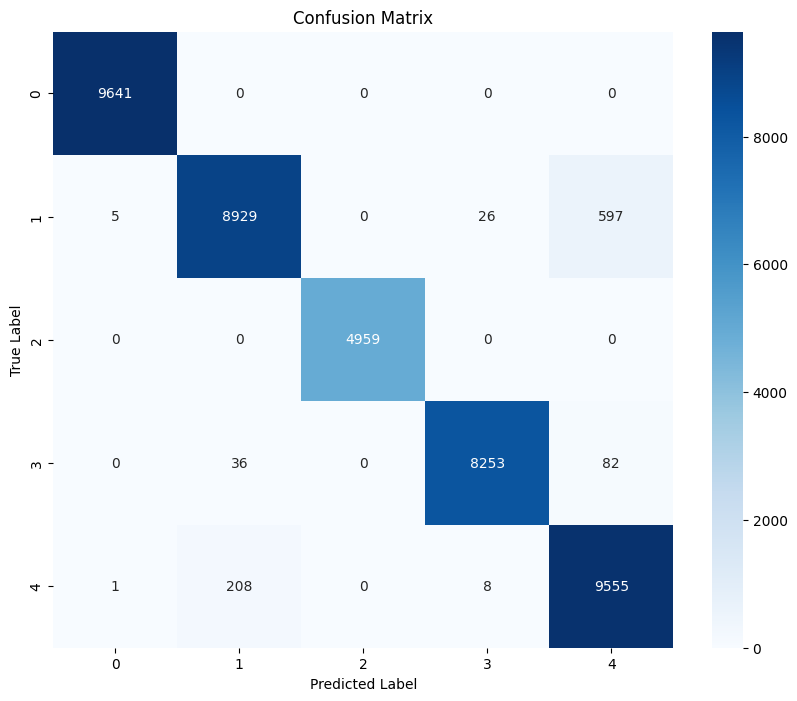


Predictions saved to 'target_data_with_predictions.csv'


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.linalg import svd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets from CSV files
source_file = 'source_data_clean.csv'
target_file = 'target_data_clean.csv'

# Load data
df_source = pd.read_csv(source_file)
df_target = pd.read_csv(target_file)

# Assume the last column is the label and the rest are features
X_source = df_source[['Energy', 'Variance', 'Amplitude']]
y_source = df_source.iloc[:, -1]
X_target = df_target[['Energy', 'Variance', 'Amplitude']]
y_target = df_target.iloc[:, -1]

def reverse_align_features(source, target):
    """Align source features to target features using CORAL."""
    cov_source = np.cov(source, rowvar=False)
    cov_target = np.cov(target, rowvar=False)
    
    # Singular Value Decomposition (SVD)
    U_s, _, _ = svd(cov_source)
    U_t, _, _ = svd(cov_target)

    # Align source covariance to target covariance
    aligned_source = source @ U_t @ np.linalg.pinv(U_s)
    return aligned_source

# Standardize the data
scaler = StandardScaler()
X_source = scaler.fit_transform(X_source)
X_target = scaler.transform(X_target)

# Align source features to target features
X_source_aligned = reverse_align_features(X_source, X_target)

# Create subsets of data
subsets = [
    ('Energy', [0]),
    ('Variance', [1]),
    ('Amplitude', [2]),
    ('Energy_Variance', [0, 1]),
    ('Energy_Amplitude', [0, 2]),
    ('Variance_Amplitude', [1, 2]),
    ('All_Features', [0, 1, 2])
]

# Initialize list to store models
models = []

# Train models on each subset
for name, indices in subsets:
    print(f"\nTraining on {name} subset:")
    
    X_source_subset = X_source_aligned[:, indices]
    X_target_subset = X_target[:, indices]
    
    # Ensure 2D arrays
    if X_source_subset.ndim == 1:
        X_source_subset = X_source_subset.reshape(-1, 1)
    if X_target_subset.ndim == 1:
        X_target_subset = X_target_subset.reshape(-1, 1)
    
    # Train on source data with slightly altered parameters
    rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=2, random_state=42)
    rf_model.fit(X_source_subset, y_source)
    
    # Evaluate using cross-validation to check performance
    cv_scores = cross_val_score(rf_model, X_source_subset, y_source, cv=5)
    print(f"Cross-Validation Accuracy: {np.mean(cv_scores):.2f}")
    
    # Fine-tune on target data
    rf_model.fit(X_target_subset, y_target)
    
    models.append((name, rf_model, indices))

# Make predictions using all models on the full target data
predictions = []
for name, model, indices in models:
    X_target_subset = X_target[:, indices]
    if X_target_subset.ndim == 1:
        X_target_subset = X_target_subset.reshape(-1, 1)
    pred = model.predict(X_target_subset)
    predictions.append(pred)

# Combine predictions (majority voting)
final_predictions = np.array([np.bincount(pred).argmax() for pred in zip(*predictions)])

# Evaluate the combined model on the full target data
print("\nClassification Report:")
print(classification_report(y_target, final_predictions))

# Calculate and print confusion matrix
cm = confusion_matrix(y_target, final_predictions)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Save predictions to a CSV file
df_target['Predicted_Label'] = final_predictions
df_target.to_csv('target_data_with_predictions.csv', index=False)
print("\nPredictions saved to 'target_data_with_predictions.csv'")

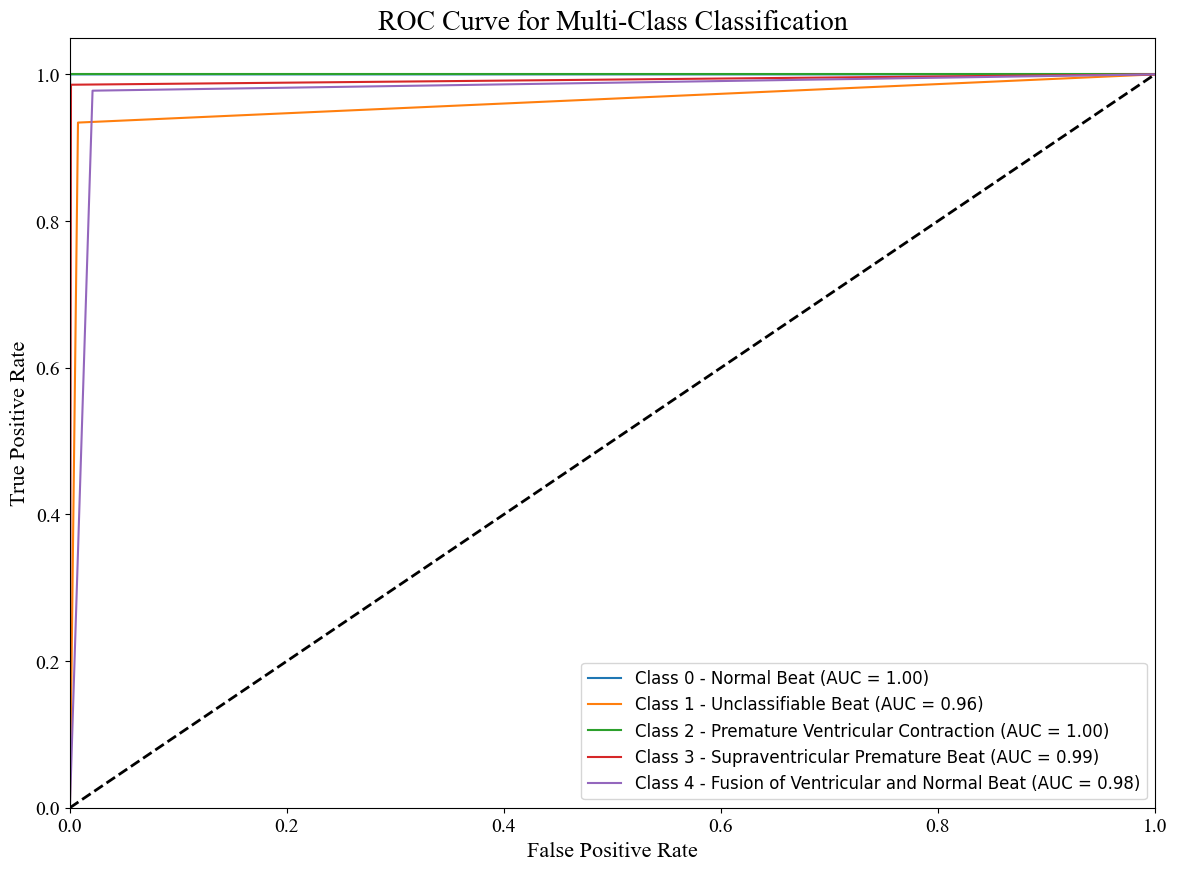

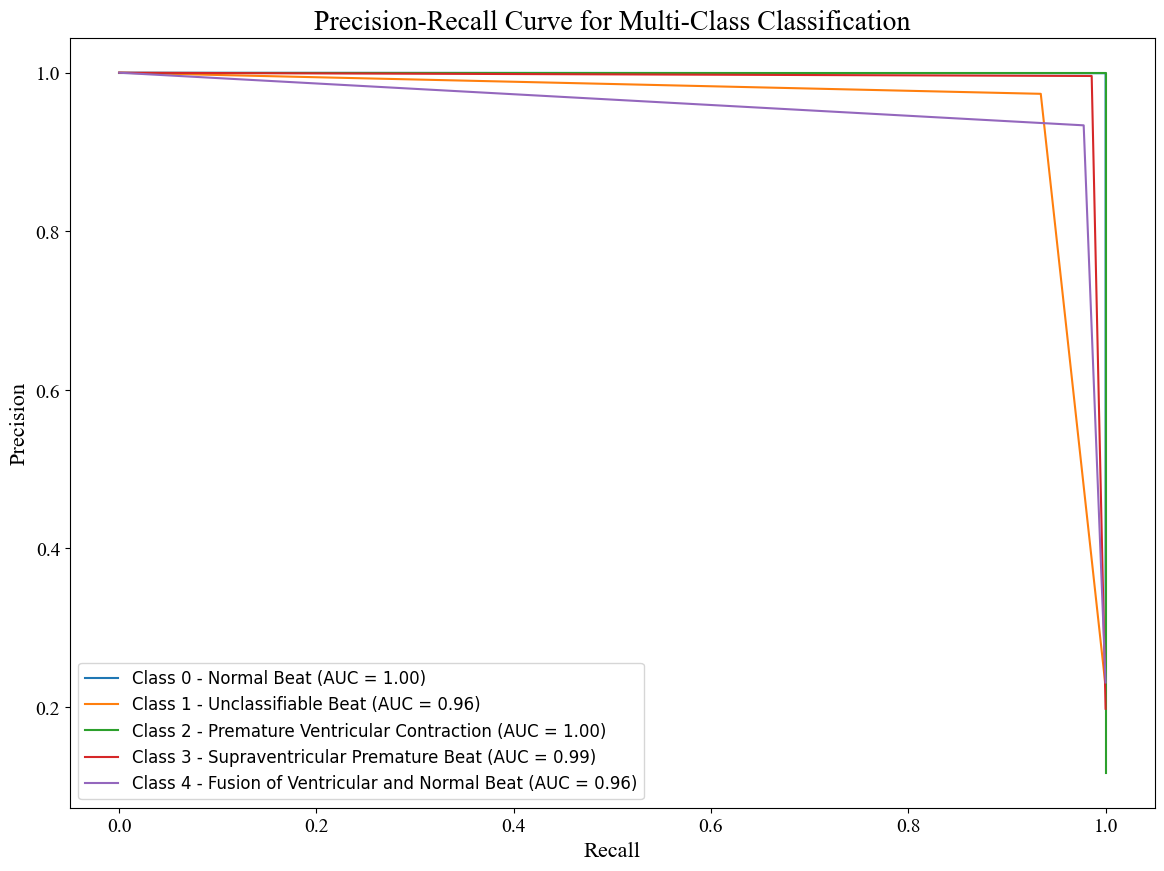

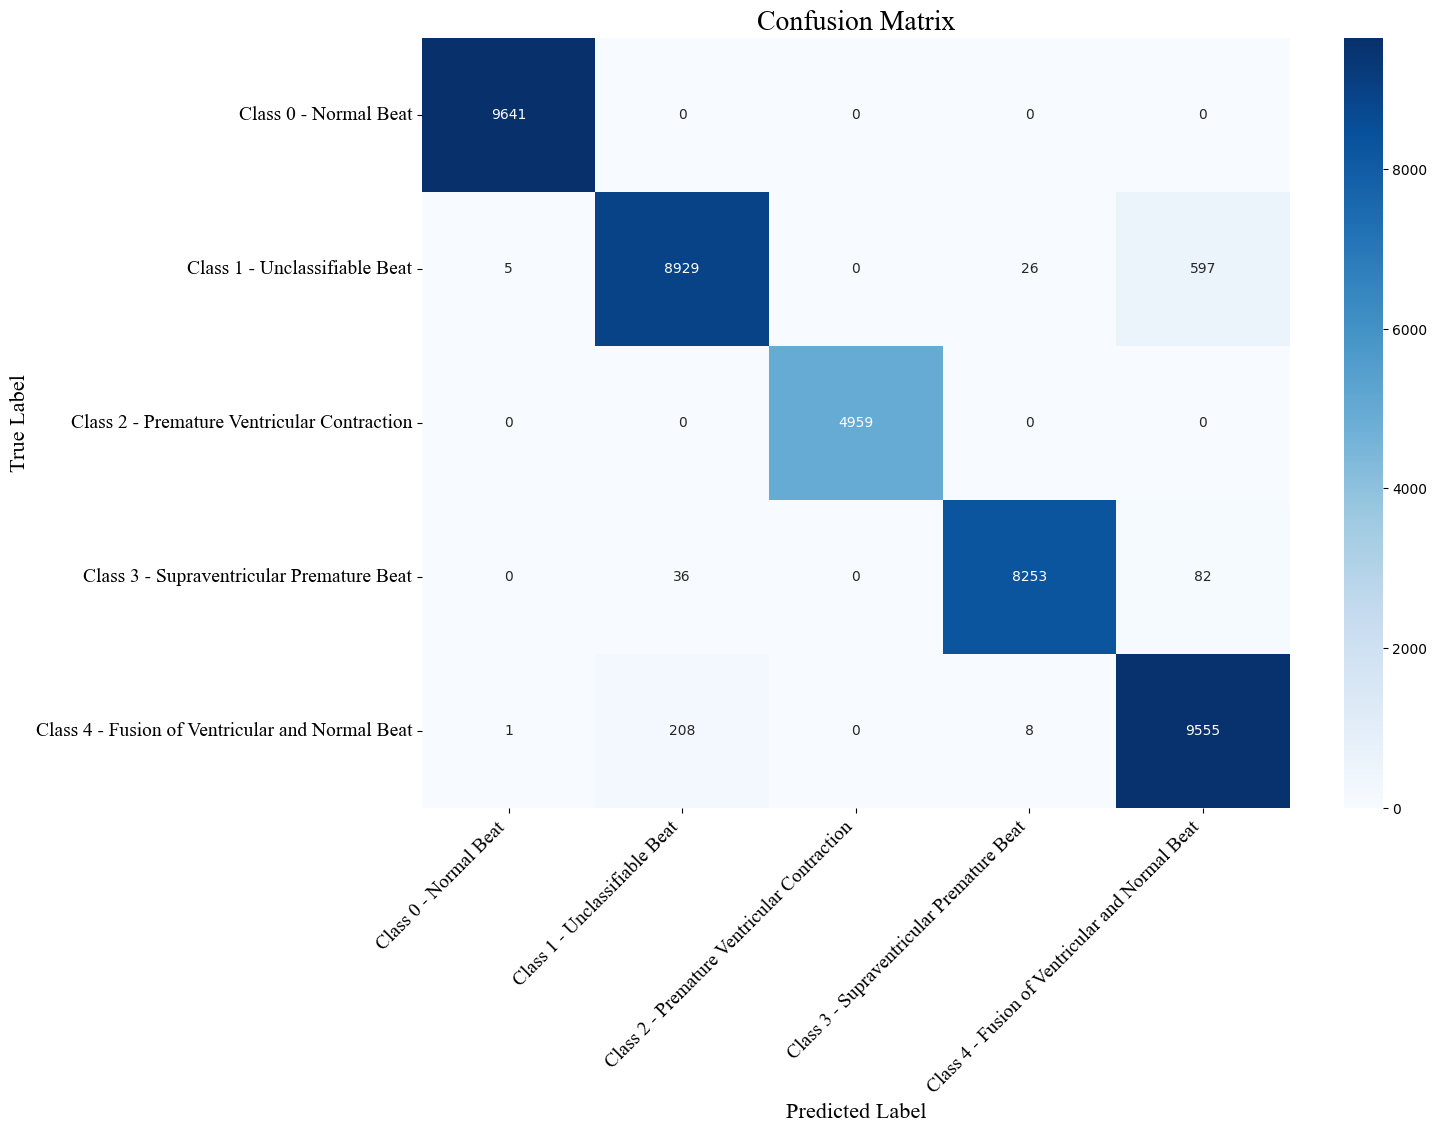

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Binarize the labels for ROC and Precision-Recall curve calculation
y_target_binarized = label_binarize(y_target, classes=[0, 1, 2, 3, 4])
n_classes = y_target_binarized.shape[1]

# Generate ROC curve and Precision-Recall curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
pr_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_target_binarized[:, i], final_predictions == i)
    roc_auc[i] = auc(fpr[i], tpr[i])
    precision[i], recall[i], _ = precision_recall_curve(y_target_binarized[:, i], final_predictions == i)
    pr_auc[i] = auc(recall[i], precision[i])

# Class names with detailed labels
class_names = [
    'Class 0 - Normal Beat', 
    'Class 1 - Unclassifiable Beat', 
    'Class 2 - Premature Ventricular Contraction', 
    'Class 3 - Supraventricular Premature Beat', 
    'Class 4 - Fusion of Ventricular and Normal Beat'
]

# Plot ROC curves
plt.figure(figsize=(14, 10))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16, fontname='Times New Roman')
plt.ylabel('True Positive Rate', fontsize=16, fontname='Times New Roman')
plt.title('ROC Curve for Multi-Class Classification', fontsize=20, fontname='Times New Roman')
plt.legend(loc="lower right", fontsize=12)
plt.xticks(fontsize=14, fontname='Times New Roman')
plt.yticks(fontsize=14, fontname='Times New Roman')
plt.show()

# Plot Precision-Recall curves
plt.figure(figsize=(14, 10))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f'{class_names[i]} (AUC = {pr_auc[i]:.2f})')

plt.xlabel('Recall', fontsize=16, fontname='Times New Roman')
plt.ylabel('Precision', fontsize=16, fontname='Times New Roman')
plt.title('Precision-Recall Curve for Multi-Class Classification', fontsize=20, fontname='Times New Roman')
plt.legend(loc="lower left", fontsize=12)
plt.xticks(fontsize=14, fontname='Times New Roman')
plt.yticks(fontsize=14, fontname='Times New Roman')
plt.show()

# Plot Confusion Matrix with custom labels
cm = confusion_matrix(y_target, final_predictions)
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=20, fontname='Times New Roman')
plt.ylabel('True Label', fontsize=16, fontname='Times New Roman')
plt.xlabel('Predicted Label', fontsize=16, fontname='Times New Roman')
plt.xticks(fontsize=14, fontname='Times New Roman', rotation=45, ha='right')
plt.yticks(fontsize=14, fontname='Times New Roman', rotation=0)
plt.show()


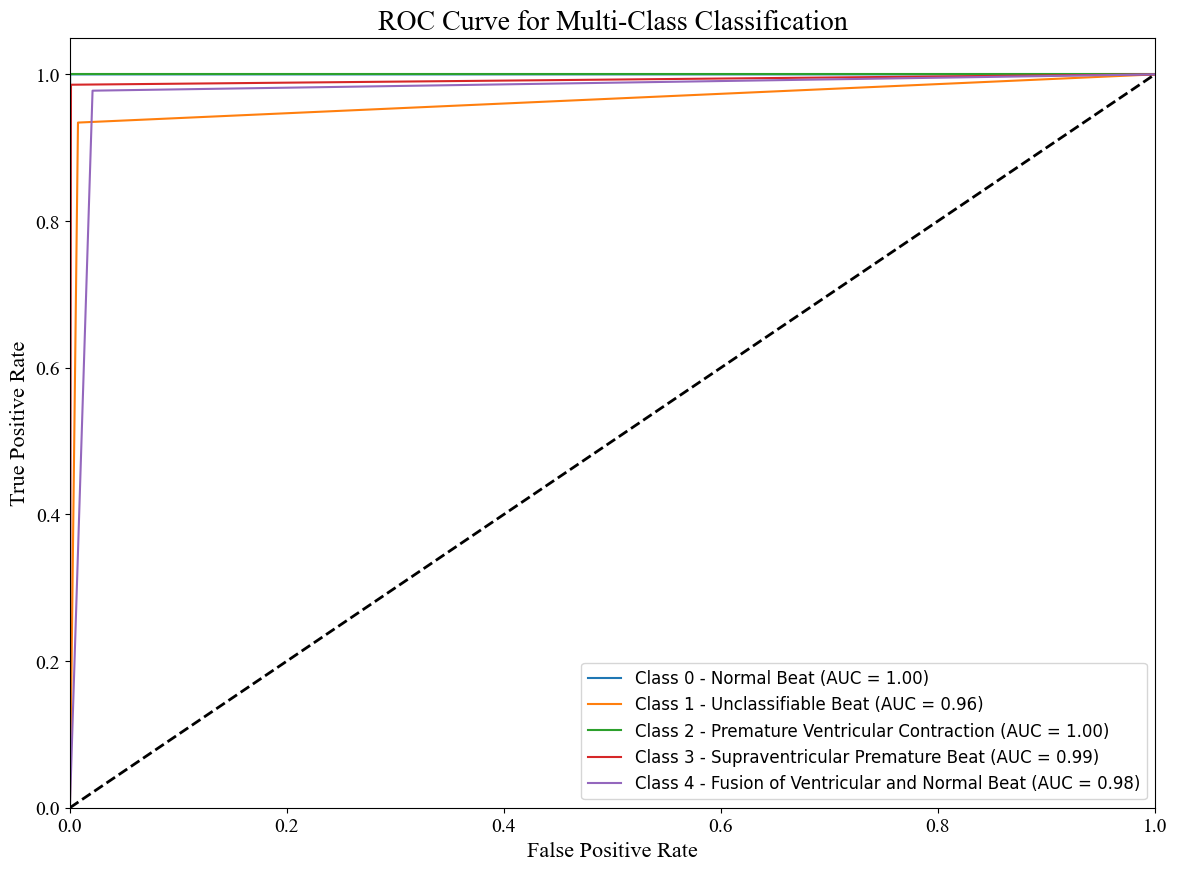

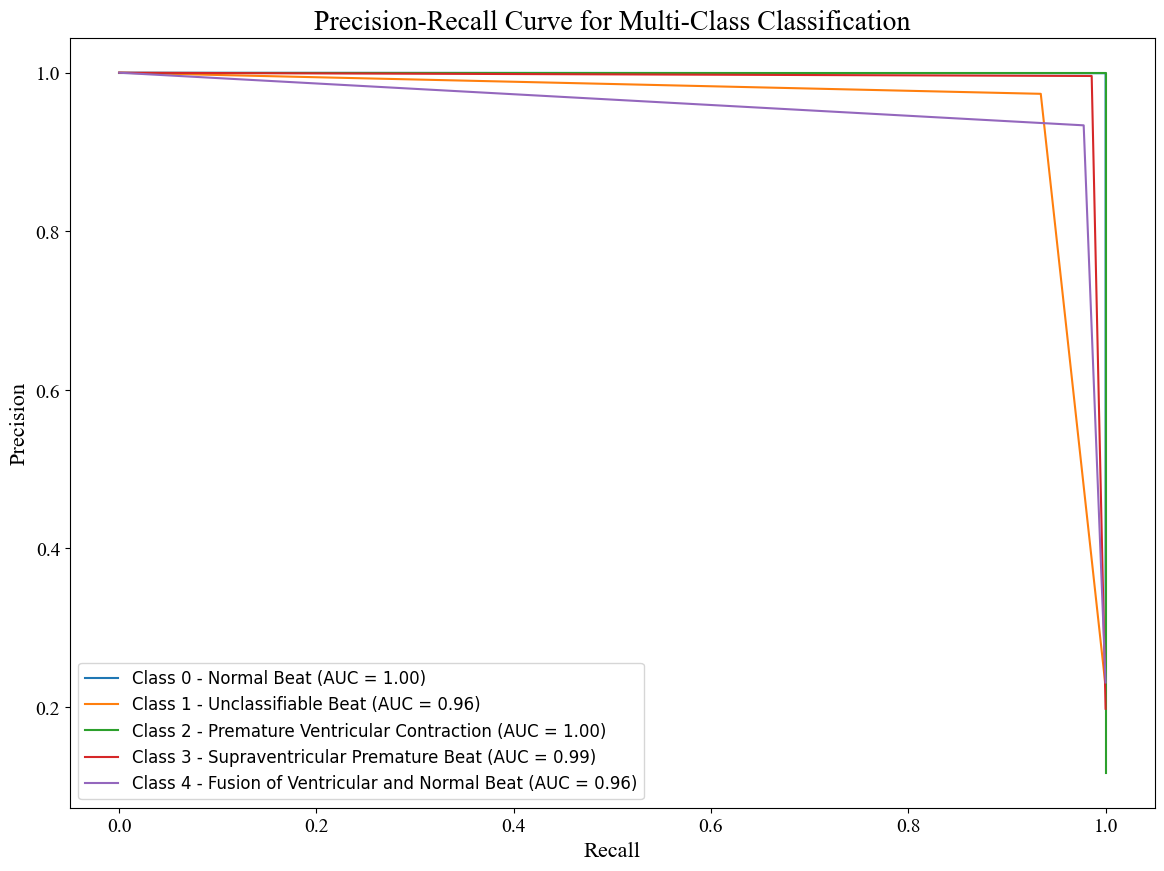

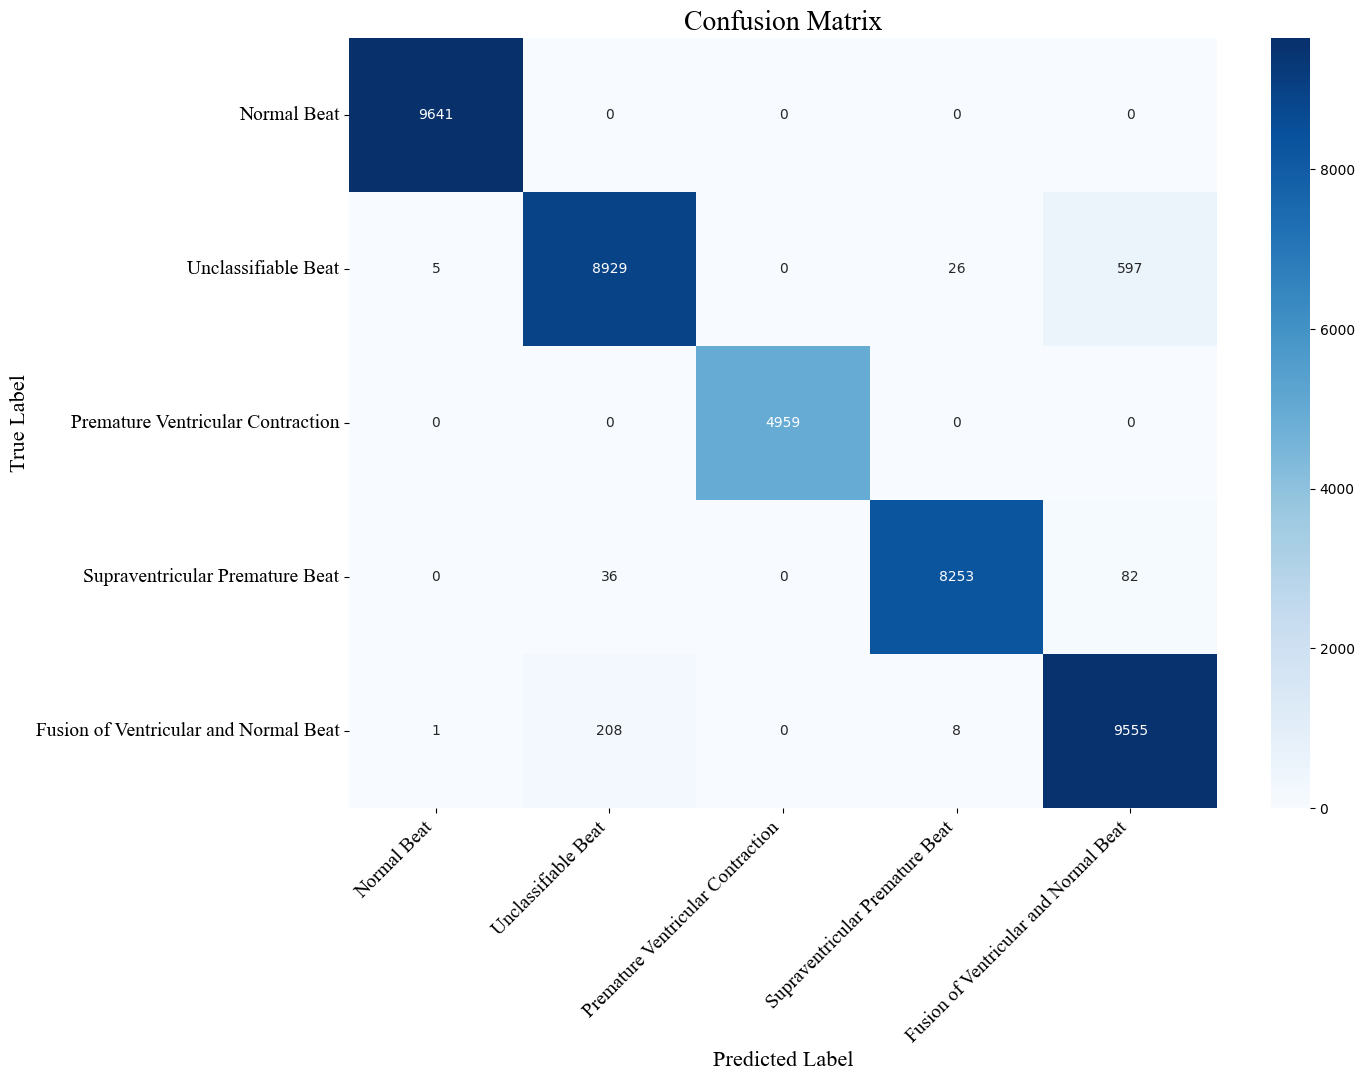

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Binarize the labels for ROC and Precision-Recall curve calculation
y_target_binarized = label_binarize(y_target, classes=[0, 1, 2, 3, 4])
n_classes = y_target_binarized.shape[1]

# Generate ROC curve and Precision-Recall curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
pr_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_target_binarized[:, i], final_predictions == i)
    roc_auc[i] = auc(fpr[i], tpr[i])
    precision[i], recall[i], _ = precision_recall_curve(y_target_binarized[:, i], final_predictions == i)
    pr_auc[i] = auc(recall[i], precision[i])

# Class names with detailed labels for ROC and Precision-Recall curves
detailed_class_names = [
    'Class 0 - Normal Beat', 
    'Class 1 - Unclassifiable Beat', 
    'Class 2 - Premature Ventricular Contraction', 
    'Class 3 - Supraventricular Premature Beat', 
    'Class 4 - Fusion of Ventricular and Normal Beat'
]

# Plot ROC curves
plt.figure(figsize=(14, 10))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{detailed_class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16, fontname='Times New Roman')
plt.ylabel('True Positive Rate', fontsize=16, fontname='Times New Roman')
plt.title('ROC Curve for Multi-Class Classification', fontsize=20, fontname='Times New Roman')
plt.legend(loc="lower right", fontsize=12)
plt.xticks(fontsize=14, fontname='Times New Roman')
plt.yticks(fontsize=14, fontname='Times New Roman')
plt.show()

# Plot Precision-Recall curves
plt.figure(figsize=(14, 10))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f'{detailed_class_names[i]} (AUC = {pr_auc[i]:.2f})')

plt.xlabel('Recall', fontsize=16, fontname='Times New Roman')
plt.ylabel('Precision', fontsize=16, fontname='Times New Roman')
plt.title('Precision-Recall Curve for Multi-Class Classification', fontsize=20, fontname='Times New Roman')
plt.legend(loc="lower left", fontsize=12)
plt.xticks(fontsize=14, fontname='Times New Roman')
plt.yticks(fontsize=14, fontname='Times New Roman')
plt.show()

# Class names without "Class 0", "Class 1", etc. for confusion matrix
class_names = [
    'Normal Beat', 
    'Unclassifiable Beat', 
    'Premature Ventricular Contraction', 
    'Supraventricular Premature Beat', 
    'Fusion of Ventricular and Normal Beat'
]

# Plot Confusion Matrix with custom labels
cm = confusion_matrix(y_target, final_predictions)
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=20, fontname='Times New Roman')
plt.ylabel('True Label', fontsize=16, fontname='Times New Roman')
plt.xlabel('Predicted Label', fontsize=16, fontname='Times New Roman')
plt.xticks(fontsize=14, fontname='Times New Roman', rotation=45, ha='right')
plt.yticks(fontsize=14, fontname='Times New Roman', rotation=0)
plt.show()